# Render thank you message

In [28]:
import requests
import pandas as pd
response = requests.get("https://gciro.pythonanywhere.com/metadata")

df = pd.DataFrame(response.json())

a = df.annotator_name.unique().tolist()
names = []
for i in a:
    
    if "test" in i.lower():
        continue

    splitted = i.split(" ")
    first_name = splitted[0].capitalize().strip()
    last_name = ""
    
    if len(splitted) > 1:
        last_name = splitted[1].capitalize().strip()[0]+"."
    
    name = first_name + " " + last_name
    names.append(name.strip())

print(", ".join(names))

Tommaso D., Claudia, Claudia, Diana, Sara, Giovanni P., Matilde, Lorenzo, Francesca, Simone P.


# Inspect Trained Model (predictions + gradcam)

In [ ]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
import torch

reload(datamodule)
reload(models)
reload(saliency)

PATH_TO_CKPT = "/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/rn_True_False_0.54.ckpt"
ALPHA = 0.3
N = 5  # Number of images to sample
device = "cuda" if torch.cuda.is_available() else "cpu"

def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()

# Sample N random indices
indices = np.random.choice(len(dm.test_ds), N, replace=False)
# indices = np.arange(390, 309+N)
# Fetch the corresponding batch of images
images = []
labels = []
for idx in indices:
    X, y = dm.test_ds[idx]
    images.append(X)
    labels.append(y)

# Convert lists to tensors
X = torch.stack(images).to(device)
y = torch.tensor(labels).to(device)

model = models.BaseCNN.load_from_checkpoint(PATH_TO_CKPT).to(device)
model.eval()
pred = model.predict(X)

gcam = saliency.CAM(model.model)
cams = []

for i in range(N):
    single_cam = gcam(X[[i]])  # Add batch dimension with X[[i]]
    cams.append(single_cam)
# Plotting
fig, axes = plt.subplots(N, 2, figsize=(5, 3*N))  # Adjust figure size as needed

for i in range(N):
    # Original Image
    img = X[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original (Label: {y[i].item()}")

    # GradCAM Overlay
    overlay = overlay_gradcam_on_image(X[i:i+1], cams[i], alpha=ALPHA)
    axes[i, 1].imshow(overlay)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Saliency (Pred: {pred[i].item()})")

plt.tight_layout()
plt.show()

# Parse the content of the .json in /evaluation/ and write to a .csv

In [55]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics_name = set(k.replace("test/", "").split("_")[0]for k in results.keys())

    for name in metrics_name:
        metrics[name] = {
            "mean": results[f'test/{name}_mean'],
            "pm": (results[f'test/{name}_ci_upper'] - results[f'test/{name}_ci_lower'])/2
        }
    return metrics

payload = "model,linear,pretrained"


for i, evals in enumerate(sorted(os.listdir("evaluation"))):
    
    # Opne json
    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)

    # Format csv row
    model, linear, pretrained = evals.split("_")[:3]
    metrics = parse_json_and_format_for_latex(res)

    # Add header 
    if i == 0:
        for name in metrics.keys():
            payload += f",{name},pm"
        payload += "\n"

    # Add values
    payload += f"{model},{linear},{pretrained}"
    for name in metrics.keys():
        mean = metrics[name]["mean"] * 100
        pm = metrics[name]["pm"] * 100
        payload += f",{mean},{pm}"
    payload+="\n"

# Dump to csv
with open("plots/results.csv", "w") as f:
    f.write(payload)

# Read .csv with results and create latex table

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('plots/results.csv')

# Process the data to restructure it
# Map "linear" column to "Adapted Classifier" for the table
df['adapted_classifier'] = df['linear'].map({True: 'Yes', False: 'No'})
df['pretrained_text'] = df['pretrained'].map({True: 'Yes', False: 'No'})

# Format metrics with their plus/minus values
metrics = ['accuracy', 'f1', 'auroc', 'specificity']  # Changed to use accuracy and f1 instead of precision and recall
for i, row in df.iterrows():
    for metric in metrics:
        # Assuming the pm column follows each metric column
        metric_idx = df.columns.get_loc(metric)
        pm_idx = metric_idx + 1
        
        # Format the value with its plus/minus
        if pd.notna(row[metric]) and pd.notna(row[df.columns[pm_idx]]):
            df.at[i, f"{metric}_formatted"] = f"{row[metric]:.2f} $\\pm$ {row[df.columns[pm_idx]]:.2f}"
        else:
            df.at[i, f"{metric}_formatted"] = "- $\\pm$ -"

# Generate LaTeX table
latex_table = """\\begin{table*}[t]
    \\centering
    \\setlength{\\tabcolsep}{3pt}
    \\caption{Model Performance Metrics}
    \\begin{tabularx}{\\textwidth}{lYYYcccc}
        \\toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC & Specifity\\\\
        \\midrule
"""

# Group by model to handle the multirow structure
models = df['model'].unique()
mapped_names = {
    "vgg": "VGG-16",
    "in": "InceptionNet-V1",
    "an": "AlexNet",
    "rn": "ResNet-50",
}
for i, model in enumerate(models):
    model_df = df[df['model'] == model]
    
    # Group by pretrained status
    pretrained_values = model_df['pretrained'].unique()
    
    # Count rows for multirow
    model_rows = len(model_df)
    model_name = mapped_names[model]
    for j, pretrained in enumerate(pretrained_values):
        pretrained_df = model_df[model_df['pretrained'] == pretrained]
        pretrained_rows = len(pretrained_df)
        
        # Add pretrained status with multirow
        for k, (idx, row) in enumerate(pretrained_df.iterrows()):
            if k == 0 and j == 0:
                # First row of the model
                latex_table += f"        \\multirow{{{model_rows}}}{{*}}{{{model_name}}} &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            elif k == 0:
                # First row of a new pretrained group
                latex_table += f"         &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            else:
                # Continuation rows
                latex_table += "         &                          "

            latex_table += f" &   {row['adapted_classifier'] if model not in {'in', 'rn'} else '-'}  &   {row['accuracy_formatted']}     &   {row['f1_formatted']}    &   {row['auroc_formatted']} &   {row['specificity_formatted']}\\\\\n"
        
        # Add cmidrule between pretrained groups within the same model (except after the last pretrained group)
        if j < len(pretrained_values) - 1:
            latex_table += "        \\cmidrule(lr){2-6}\n"
    
    # Add midrule between models (except after the last model)
    if i < len(models) - 1:
        latex_table += "        \\midrule\n"

# Close the table
latex_table += """        \\bottomrule
    \\end{tabularx}
    \\label{tab:Performance}
\\end{table*}
"""

print(latex_table)
# Optionally save to a file
with open('plots/results.tex', 'w') as f:
    f.write(latex_table)

# Get nice plots from the metrics in /evaluation/

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Specify the CSV file path
CSV_FILE = "plots/results.csv"  

# Read and process the CSV file with the new format
def read_csv_and_process(csv_file_path):
    """
    Read the CSV file with structure:
    model,linear,pretrained,accuracy,pm,precision,pm,specificity,pm,recall,pm,f1,pm,auroc,pm
    """
    # Read the raw CSV
    df = pd.read_csv(csv_file_path)
    
    # Create a clean dataframe with proper structure
    processed_data = []
    
    # Calculate the number of metrics (excluding the first 3 columns and accounting for the pm columns)
    num_columns = len(df.columns)
    num_metrics = (num_columns - 3) // 2  # Each metric has a value and a pm column
    
    # Process each row
    for _, row in df.iterrows():
        model = row[0]  # model
        linear = row[1]  # linear
        pretrained = row[2]  # pretrained
        model_name = f"{model}_{linear}_{pretrained}"
        if not linear or not pretrained:
            continue
        
        # Extract metric values and their confidence intervals
        metrics_data = {}
        metrics_index = 3  # Start from the 4th column (0-indexed)
        
        # Expected metrics in order: accuracy, precision, specificity, recall, f1, auroc
        metric_names = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
        
        for i in range(num_metrics):
            if metrics_index < len(row):
                metric_name = metric_names[i] if i < len(metric_names) else f"metric_{i}"
                metrics_data[f"{metric_name}_mean"] = row[metrics_index]
                metrics_data[f"{metric_name}_ci_half"] = row[metrics_index + 1]  # pm value
                metrics_index += 2  # Move to the next metric
        
        # Create a row for the model
        processed_row = {
            'model': model,
            'linear': linear,
            'pretrained': pretrained,
            'model_name': model_name,
            **metrics_data  # Add all metrics data
        }
        
        processed_data.append(processed_row)
    
    return pd.DataFrame(processed_data)

# Create bar plots with confidence intervals for each metric
def plot_metrics(df):
    # List of metrics to plot
    metrics = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
    
    # Set up the figure size and style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Create a directory for plots if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    
    for metric in metrics:
        # Skip metrics that don't exist in the dataframe
        if f"{metric}_mean" not in df.columns:
            print(f"Skipping {metric} as it's not in the data")
            continue
            
        plt.figure()
        
        # Prepare data for plotting
        model_names = df['model_name']
        means = df[f'{metric}_mean']
        errors = df[f'{metric}_ci_half']
        
        # Create bar plot with error bars
        plt.bar(model_names, means, yerr=errors, capsize=10, color='skyblue', edgecolor='black')
        
        # Customize the plot
        plt.title(f'{metric.upper()} with 95% Confidence Intervals', fontsize=16)
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the figure
        plt.savefig(f'plots/{metric}_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Generated plots for available metrics")

# Create a single plot with all metrics using seaborn
def plot_all_metrics_together(df):
    # Get all metric columns
    metric_columns = [col for col in df.columns if col.endswith('_mean')]
    ci_columns = [col for col in df.columns if col.endswith('_ci_half')]
    
    # Create a long-form dataframe for seaborn
    melted_df = pd.melt(df, id_vars=['model_name'], 
                        value_vars=metric_columns,
                        var_name='metric', value_name='value')
    
    # Add CI information
    melted_df['metric_base'] = melted_df['metric'].str.replace('_mean', '')
    melted_ci = pd.melt(df, id_vars=['model_name'], 
                       value_vars=ci_columns,
                       var_name='ci_metric', value_name='ci')
    melted_ci['metric_base'] = melted_ci['ci_metric'].str.replace('_ci_half', '')
    
    # Merge the dataframes
    final_df = pd.merge(melted_df, melted_ci, on=['model_name', 'metric_base'])
    
    # Clean up the metric names for display
    final_df['clean_metric'] = final_df['metric'].str.replace('_mean', '').str.capitalize()
    
    # Create the plot
    plt.figure(figsize=(18, 10))
    
    # Plot grouped bar chart
    ax = sns.barplot(x='clean_metric', y='value', hue='model_name', data=final_df)
    
    # Add error bars
    x_coords = np.arange(len(final_df['clean_metric'].unique()))
    width = 0.8 / len(df['model_name'].unique())
    
    for i, model in enumerate(df['model_name'].unique()):
        model_data = final_df[final_df['model_name'] == model]
        x_pos = x_coords - 0.4 + width * (i + 0.5)
        plt.errorbar(x=x_pos, y=model_data['value'], yerr=model_data['ci'], 
                    fmt='none', capsize=5, ecolor='black', alpha=0.75)
    
    # Customize plot
    plt.title('Performance Metrics Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save figure
    plt.savefig('plots/all_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Generated combined metrics plot")


# Create plots directory
os.makedirs("plots", exist_ok=True)

try:
    # Process the CSV file
    df = read_csv_and_process(CSV_FILE)

    # Create individual plots for each metric
    plot_metrics(df)
    
    # Create a combined plot with all metrics
    plot_all_metrics_together(df)
    
except FileNotFoundError:
    raise Exception(f"CSV file '{CSV_FILE}' not found. Please make sure the file exists.")

# Exploring Annotations

### 1. Imports and Setup

In [34]:
import json
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import importlib
from torchvision import transforms
import cv2

import utils


BASE_ANNOTATIONS_DIR = "data/annotations"
METADATA_PATH = os.path.join(BASE_ANNOTATIONS_DIR, "metadata.json")
ANNOTATED_MASKS_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "annotated")
ORIGINAL_IMAGES_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "original")

TARGET_MASK_SIZE = (224, 224)

# Parameters for updated utils.process_circled_annotation TO BE TUNED!

CIRCLE_CLOSING_KERNEL_SIZE = 7 
CIRCLE_EROSION_KERNEL_SIZE = 7 
MIN_CONTOUR_AREA_FILTER = 20   

INITIAL_PRE_CLOSING_KERNEL_SIZE = 3  # For initial small gap closing (0 to disable)
SOLIDITY_THRESHOLD = 0.6             # Solidity < threshold means it's an OUTLINE. Range (0.0 to 1.0)
                                     # Lower for thinner/more broken outlines, Higher if outlines are quite solid.
OUTLINE_FILL_CLOSING_KERNEL_SIZE = 7 # To close gaps in detected outlines before filling (0 to disable)
OUTLINE_EROSION_KERNEL_SIZE = 7      # To "remove" line thickness from filled OUTLINES (0 to disable)
FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE = 5 # To close internal holes in detected FILLED regions (0 to disable)
MIN_CONTOUR_AREA_FILTER = 20         # Minimum pixel area to consider a contour significant



### 2. Basics Statistics from Metadata

In [35]:
with open(METADATA_PATH, 'r') as f:
        annotations_metadata_raw = json.load(f)
print(f"Successfully loaded metadata from: {METADATA_PATH}")
print(f"Total records in metadata: {len(annotations_metadata_raw)}")
# Convert to DataFrame for easier analysis
df_metadata_raw = pd.DataFrame(annotations_metadata_raw)
    
# --- Apply Filter to Exclude Test Annotators ---
df_metadata = df_metadata_raw[~df_metadata_raw['annotator_name'].str.contains('test', case=False, na=False)].copy()
# Create a filtered list of dictionaries for functions that expect list format
annotations_metadata = df_metadata.to_dict(orient='records')

print(f"\nApplied filter. Records remaining after excluding 'test' annotators: {len(df_metadata)}")
if len(df_metadata) < len(df_metadata_raw):
    excluded_count = len(df_metadata_raw) - len(df_metadata)
print(f"  Excluded {excluded_count} records from 'test' annotators.")

Successfully loaded metadata from: data/annotations/metadata.json
Total records in metadata: 125

Applied filter. Records remaining after excluding 'test' annotators: 120
  Excluded 5 records from 'test' annotators.



--- Basic Statistics ---
Number of unique images with annotations: 50

Annotations per annotator:
annotator_name
giovanni p          50
Sara                20
Claudia             12
Lorenzo             10
Francesca           10
claudia              7
Simone Pasini        6
matilde              3
Tommaso Danielli     1
Diana                1
Name: count, dtype: int64

Annotator professions (one per annotator):
annotator_name
Claudia                Studente di medicina
Diana                  Studente di medicina
Francesca           Studentessa di medicina
Lorenzo                Studente di medicina
Sara                         Specializzanda
Simone Pasini             Medico internista
Tommaso Danielli       Studente di medicina
claudia                studente di medicina
giovanni p                 medico radiologo
matilde                   studente medicina
Name: annotator_profession, dtype: object

Total number of annotations: 120

Annotations per image (distribution):
count    50.0000

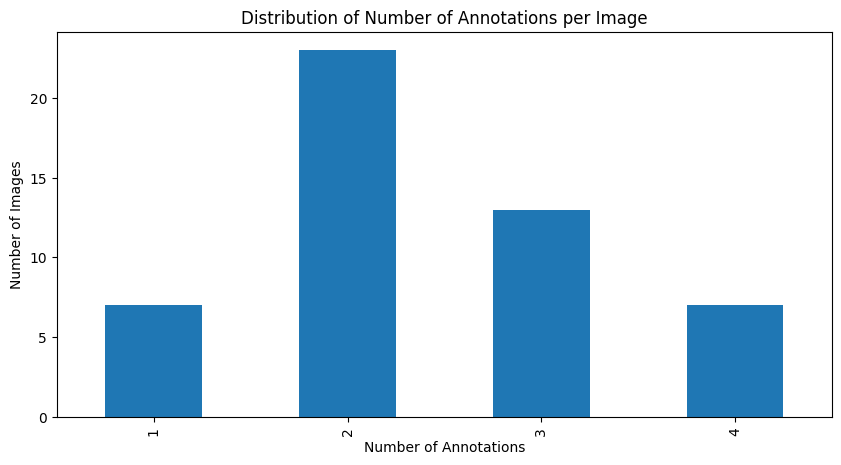

In [38]:
print("\n--- Basic Statistics ---")

num_unique_images = df_metadata['image_name'].nunique()
print(f"Number of unique images with annotations: {num_unique_images}")

print("\nAnnotations per annotator:")
print(df_metadata['annotator_name'].value_counts())

print("\nAnnotator professions (one per annotator):")
print(df_metadata.groupby('annotator_name')['annotator_profession'].first())

total_annotations = len(df_metadata)
print(f"\nTotal number of annotations: {total_annotations}")

print("\nAnnotations per image (distribution):")
annotations_per_image = df_metadata.groupby('image_name').size()
print(annotations_per_image.describe())

# Plot distribution of annotations per image
if not annotations_per_image.empty:
    plt.figure(figsize=(10, 5))
    annotations_per_image.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Number of Annotations per Image')
    plt.xlabel('Number of Annotations')
    plt.ylabel('Number of Images')
    plt.show()

### 3. Visualizing annotations


--- Testing utils.py and Visualizing ---

Processing image: person89_bacteria_440.jpeg
  Loaded original image from: data/annotations/original/person89_bacteria_440.jpeg
  Found 3 raw individual mask(s) for person89_bacteria_440.jpeg.
  Processing raw masks with 'utils.process_circled_annotation'...
  2 non-empty mask(s) for visualization after circle processing.
  Total 3 masks (incl. empty) sent for consensus.
  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).


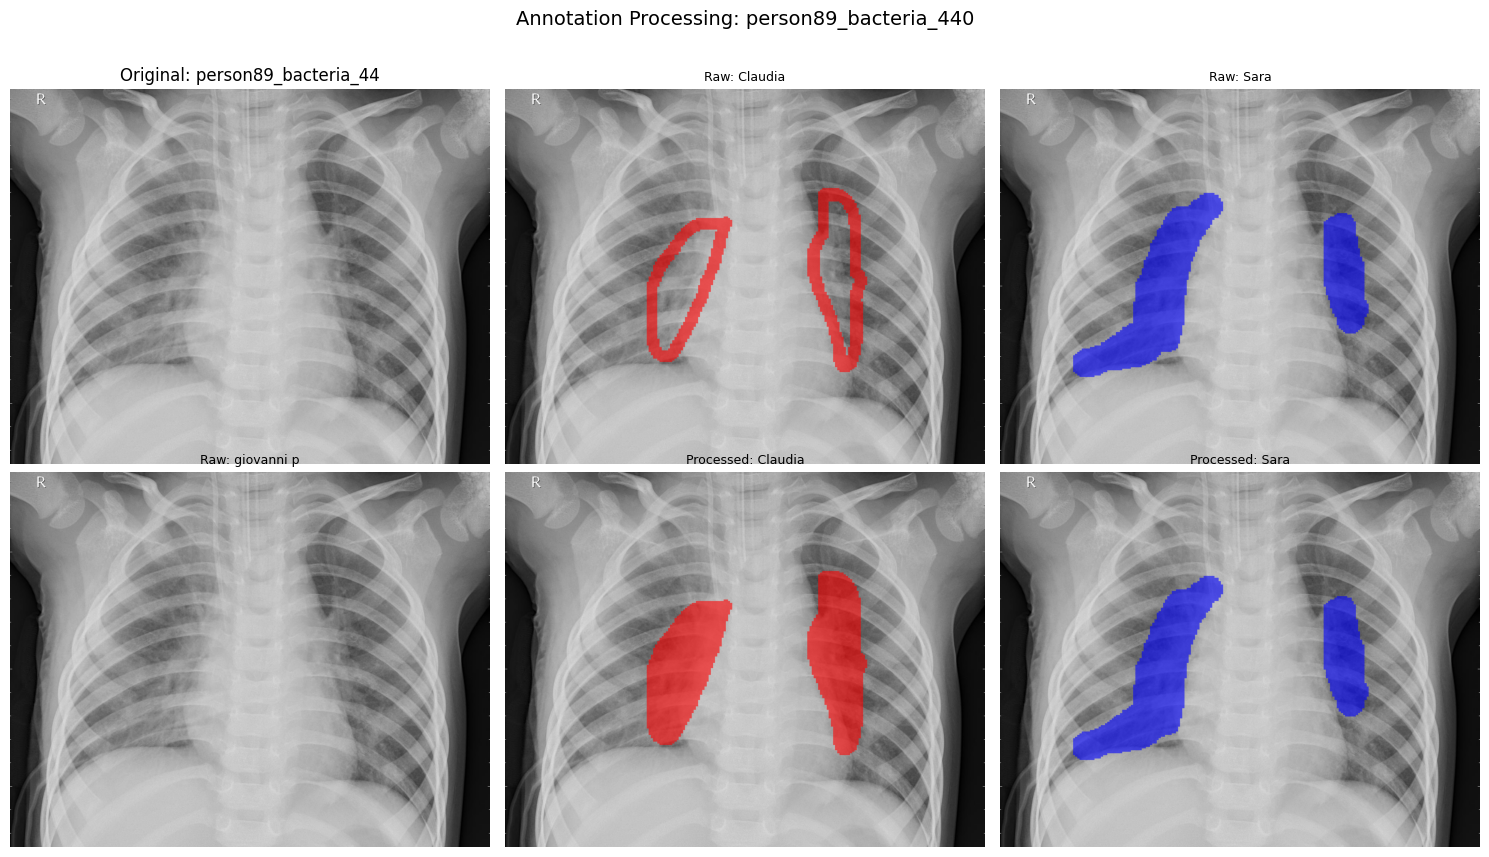


Processing image: person1647_virus_2848.jpeg
  Loaded original image from: data/annotations/original/person1647_virus_2848.jpeg
  Found 1 raw individual mask(s) for person1647_virus_2848.jpeg.
  Processing raw masks with 'utils.process_circled_annotation'...
  No non-empty masks remained after circle processing for person1647_virus_2848.jpeg (for visualization).
  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).


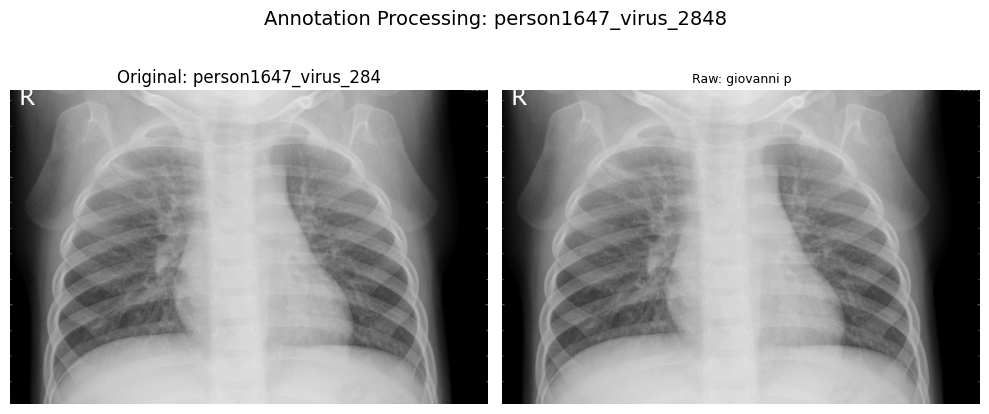

In [41]:
print("\n--- Testing utils.py and Visualizing ---")

sample_image_names = []
if not df_metadata.empty:
    image_counts = df_metadata['image_name'].value_counts()
    # Try to pick images with multiple annotations for diverse testing
    multi_annot_images = image_counts[image_counts > 1].index.tolist()
    single_annot_images = image_counts[image_counts == 1].index.tolist()
    
    if len(multi_annot_images) >= 1: # Prioritize multi-annotation images
        sample_image_names.extend(np.random.choice(multi_annot_images, size=min(1, len(multi_annot_images)), replace=False))
    if len(sample_image_names) < 2 and single_annot_images: # Fill with single annotation images if needed
            sample_image_names.extend(np.random.choice(single_annot_images, size=min(2-len(sample_image_names), len(single_annot_images)), replace=False))
    if not sample_image_names and not image_counts.empty: # Fallback
        sample_image_names.extend(np.random.choice(image_counts.index, size=min(2, len(image_counts.index)), replace=False))

if not sample_image_names:
    print("Could not select sample image names from metadata for visualization.")

for image_name in sample_image_names:
    print(f"\nProcessing image: {image_name}")
    original_image_path = os.path.join(ORIGINAL_IMAGES_DIR, image_name)
    try:
        original_pil_img = Image.open(original_image_path).convert("RGB")
        print(f"  Loaded original image from: {original_image_path}")
    except FileNotFoundError:
        print(f"  ERROR: Original image not found at {original_image_path}")
        continue
        
    # raw_masks_with_annotators will be a list of tuples: [(mask_array, annotator_name), ...]
    raw_masks_with_annotators = utils.get_masks_for_image_from_metadata(
        image_name,
        annotations_metadata,
        ANNOTATED_MASKS_DIR,
        target_size=TARGET_MASK_SIZE
    )
    
    if not raw_masks_with_annotators:
        print(f"  No raw masks found or loaded for {image_name}.")
        continue
    else:
        print(f"  Found {len(raw_masks_with_annotators)} raw individual mask(s) for {image_name}.")

    # Process raw circled annotations
    processed_masks_for_consensus_input = [] # This list will hold a mask for each annotator
    print(f"  Processing raw masks with 'utils.process_circled_annotation'...")
    for raw_mask, annotator_name in raw_masks_with_annotators: # raw_masks_with_annotators contains a mask for everyone
        processed_mask_output = utils.process_circled_annotation(
            raw_mask, # raw_mask itself could be an empty array if load_mask returned that
            initial_closing_kernel_size=INITIAL_PRE_CLOSING_KERNEL_SIZE,
            solidity_threshold=SOLIDITY_THRESHOLD,
            outline_fill_closing_kernel_size=OUTLINE_FILL_CLOSING_KERNEL_SIZE,
            outline_erosion_kernel_size=OUTLINE_EROSION_KERNEL_SIZE,
            filled_region_hole_closing_kernel_size=FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE,
            min_contour_area=MIN_CONTOUR_AREA_FILTER
        )
        # Ensure process_circled_annotation always returns a mask (even if empty), not None
        if processed_mask_output is None:
                # This should ideally be handled inside process_circled_annotation to return empty array
                processed_mask_output = np.zeros(TARGET_MASK_SIZE, dtype=np.uint8)
        processed_masks_for_consensus_input.append(processed_mask_output) # Add all, even if empty

    # For visualization, we might still want to only show non-empty processed masks
    processed_masks_with_annotators_for_viz = []
    for i, (raw_mask_orig, annotator_name_orig) in enumerate(raw_masks_with_annotators):
        # Use the corresponding mask from processed_masks_for_consensus_input for visualization
        # This ensures we visualize what was actually sent for consensus
        corresponding_processed_mask = processed_masks_for_consensus_input[i]
        if corresponding_processed_mask.sum() > 0: # Only add to viz list if it has content
                processed_masks_with_annotators_for_viz.append((corresponding_processed_mask, annotator_name_orig))
    
    if not processed_masks_with_annotators_for_viz: # Check the list for visualization
        print(f"  No non-empty masks remained after circle processing for {image_name} (for visualization).")
    else:
        print(f"  {len(processed_masks_with_annotators_for_viz)} non-empty mask(s) for visualization after circle processing.")
        print(f"  Total {len(processed_masks_for_consensus_input)} masks (incl. empty) sent for consensus.")


    consensus_mask_np = None
    # Always attempt consensus if there were annotators, create_consensus_mask will handle empty list if needed
    # The list processed_masks_for_consensus_input will have one entry per annotator.
    if raw_masks_with_annotators: # Check if there were any raw masks to begin with
        consensus_mask_np = utils.create_consensus_mask(
            processed_masks_for_consensus_input, # Pass the list that includes potentially empty masks
            filter_type='open', 
            filter_kernel_size=3,
            consensus_method='intersection'
        )
        if consensus_mask_np is not None and consensus_mask_np.sum() > 0:
            print(f"  Consensus mask created with shape: {consensus_mask_np.shape}, Sum: {consensus_mask_np.sum()}")
        else:
            print("  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).")
    else:
        print("  No raw masks available to create a consensus.")

    # Visualization
    num_raw_masks = len(raw_masks_with_annotators)
    num_processed_masks_viz = len(processed_masks_with_annotators_for_viz)

    total_plots = 1 + num_raw_masks + num_processed_masks_viz + (1 if consensus_mask_np is not None and consensus_mask_np.sum() > 0 else 0)
    
    if total_plots == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(original_pil_img)
            ax.set_title(f"Original: {image_name.split('.')[0][:20]}")
            ax.axis('off')
    else:
        cols = min(total_plots, 3) # Adjusted to 3 for potentially longer titles
        rows = (total_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4.5)) # Slightly taller for titles
        if total_plots == 1: axes = [axes]
        else: axes = axes.flatten()
        
        plot_idx = 0

        if plot_idx < len(axes): # Original Image
            axes[plot_idx].imshow(original_pil_img)
            axes[plot_idx].set_title(f"Original: {image_name.split('.')[0][:20]}")
            axes[plot_idx].axis('off'); plot_idx += 1

        colors = [(255,0,0), (0,0,255), (255,255,0), (0,255,255), (255,0,255)] 

        # Raw Individual Mask Overlays with Annotator Name
        for i, (raw_mask, annotator_name) in enumerate(raw_masks_with_annotators):
            if plot_idx < len(axes) and raw_mask is not None:
                overlay_raw_pil = utils.overlay_binary_mask(original_pil_img.copy(), raw_mask, mask_color=colors[i % len(colors)], alpha=0.6)
                axes[plot_idx].imshow(overlay_raw_pil)
                title_text = f"Raw: {annotator_name[:15]}" # Truncate annotator name if too long
                if len(annotator_name) > 15: title_text += "..."
                axes[plot_idx].set_title(title_text, fontsize=9) # Smaller font for potentially long names
                axes[plot_idx].axis('off'); plot_idx += 1
        
        # Processed Individual Mask Overlays with Annotator Name
        for i, (processed_mask, annotator_name) in enumerate(processed_masks_with_annotators_for_viz):
            if plot_idx < len(axes) and processed_mask is not None:
                overlay_processed_pil = utils.overlay_binary_mask(original_pil_img.copy(), processed_mask, mask_color=colors[i % len(colors)], alpha=0.6)
                axes[plot_idx].imshow(overlay_processed_pil)
                title_text = f"Processed: {annotator_name[:10]}" # Truncate
                if len(annotator_name) > 10: title_text += "..."
                axes[plot_idx].set_title(title_text, fontsize=9)
                axes[plot_idx].axis('off'); plot_idx += 1

        # Overlay Consensus Mask
        if consensus_mask_np is not None and consensus_mask_np.sum() > 0 and plot_idx < len(axes):
            overlay_consensus_pil = utils.overlay_binary_mask(original_pil_img.copy(), consensus_mask_np, mask_color=(0, 255, 0), alpha=0.5)
            axes[plot_idx].imshow(overlay_consensus_pil)
            axes[plot_idx].set_title("Final Consensus", fontsize=9)
            axes[plot_idx].axis('off'); plot_idx += 1
        
        for i in range(plot_idx, len(axes)): axes[i].axis('off')

    plt.suptitle(f"Annotation Processing: {image_name.split('.')[0][:30]}", fontsize=14)
    plt.tight_layout(rect=[0, 0.02, 1, 0.96]) # Adjust rect to prevent suptitle overlap
    plt.show()
    

### 4. IoU Examples

In [42]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

import utils 
from models import BaseCNN, AlexNetBinary, VGG16Binary, ResNet50Binary, InceptionNetBinary
import saliency

# --- Configuration for this cell ---
# Choose a model to load and a saliency method
# Model short keys: "an", "vgg", "rn", "in"

# RISE parameters (if chosen)
RISE_NUM_MASKS_VIS = 200 # Fewer masks for faster visualization in notebook
RISE_SCALE_FACTOR_VIS = 16

# Path to original images (ensure this aligns with where your *test* set images are,
# as annotations are typically on test/evaluation set images)
# This should be the directory containing PNEUMONIA/NORMAL subfolders or images directly
VIS_ORIGINAL_IMAGES_DIR = "data/test" # Or "data/annotations/original/" if those are the ones to use

# Get device
device = utils.get_device() if 'utils' in sys.modules and hasattr(utils, 'get_device') else torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for saliency visualization: {device}")

# Helper to load a specific model checkpoint
# Assumes CHECKPOINT_DIR is defined (e.g. "./checkpoints")
if 'CHECKPOINT_DIR' not in globals(): CHECKPOINT_DIR = "./checkpoints"

loaded_saliency_model = None
saliency_model_name_display = "Unknown"

if MODEL_SHORT_KEY_FOR_SALIENCY:
    checkpoint_path_vis = utils.find_checkpoint(MODEL_SHORT_KEY_FOR_SALIENCY) # Use the revised find_checkpoint
    if checkpoint_path_vis:
        try:
            print(f"Loading model for saliency from: {checkpoint_path_vis}")
            pl_model_wrapper_vis = BaseCNN.load_from_checkpoint(checkpoint_path_vis, map_location=device)
            loaded_saliency_model = pl_model_wrapper_vis.model
            loaded_saliency_model.to(device).eval()
            saliency_model_name_display = f"{MODEL_SHORT_KEY_FOR_SALIENCY.upper()} model"
            print(f"Successfully loaded {saliency_model_name_display}")
        except Exception as e:
            print(f"Error loading model {MODEL_SHORT_KEY_FOR_SALIENCY} from {checkpoint_path_vis}: {e}")
            loaded_saliency_model = None
    else:
        print(f"No checkpoint found for model key '{MODEL_SHORT_KEY_FOR_SALIENCY}'. Saliency visualization will be skipped for this model.")
else:
    print("MODEL_SHORT_KEY_FOR_SALIENCY not set. Saliency visualization will be skipped.")


Using device for saliency visualization: cpu


NameError: name 'MODEL_SHORT_KEY_FOR_SALIENCY' is not defined


--- Visualizing Saliency Agreement for one image using VGG model ---
Selected image for visualization: person20_virus_51.jpeg
  Generating CAM map...
  IoU between binarized CAM and Expert Consensus: 0.4396


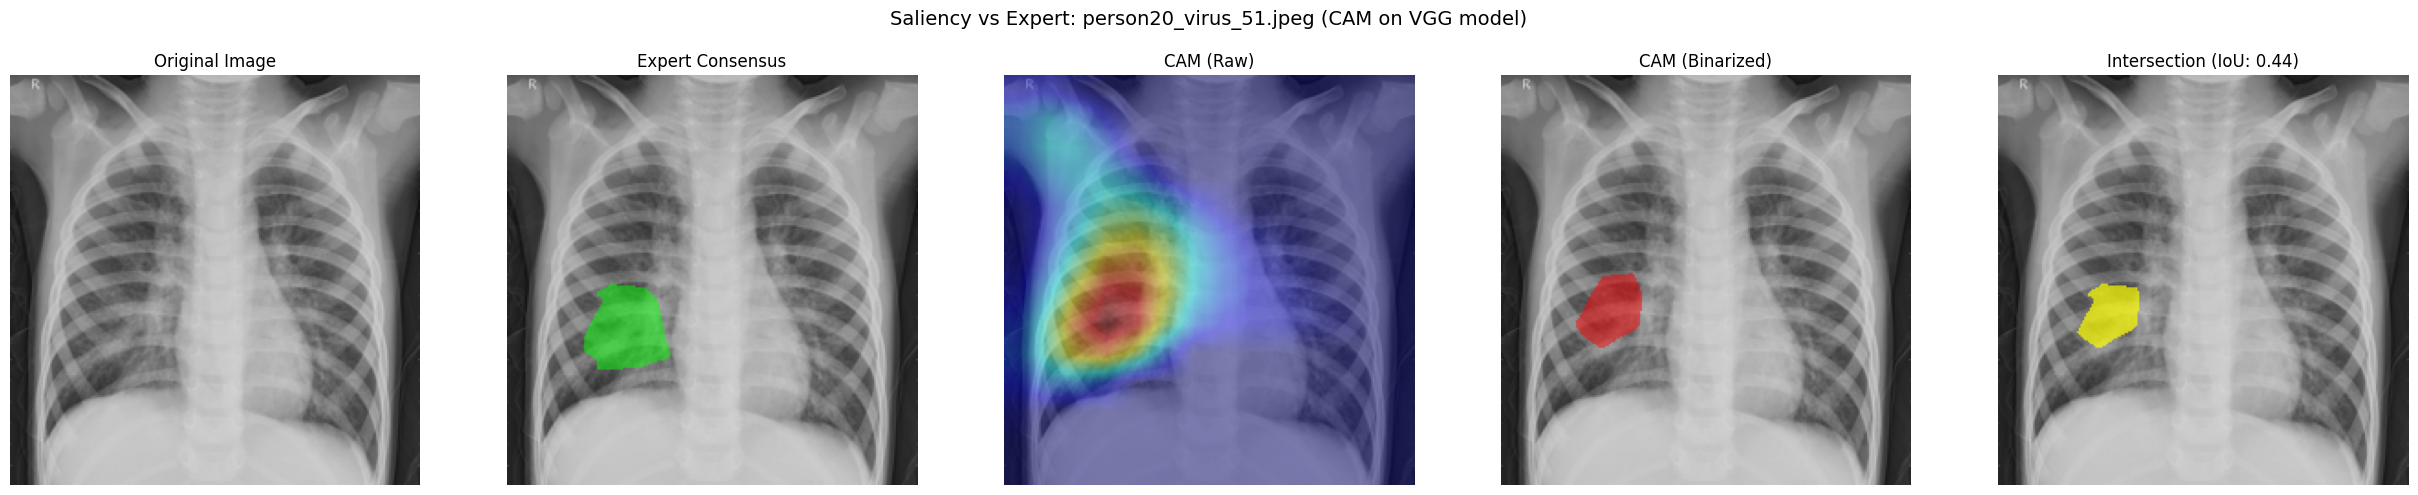

In [32]:
MODEL_INPUT_SIZE = (224, 224) 
MODEL_SHORT_KEY_FOR_SALIENCY = "vgg" # Example: AlexNet
SALIENCY_METHOD_TO_VISUALIZE = "CAM" # Options: "CAM", "GradCAM", "RISE", "Random"

# Saliency map binarization threshold (can be same as in evaluate_saliency_script.py)
VIS_SALIENCY_BINARIZATION_THRESHOLD = 0.8

print(f"\n--- Visualizing Saliency Agreement for one image using {saliency_model_name_display} ---")

# 1. Get images that have a non-empty consensus mask
# Re-using logic from evaluate_saliency_agreement.py's get_consensus_masks_for_evaluation
# but simplified to get a list of image names with valid consensus.

valid_consensus_image_names = []
temp_consensus_masks_dict = {} # Store temporarily to avoid recomputing for each sample

unique_images_for_vis = sorted(list(set(record['image_name'] for record in annotations_metadata))) # Uses filtered metadata

for img_name_vis in unique_images_for_vis:
    if img_name_vis in temp_consensus_masks_dict: # Already processed
        if temp_consensus_masks_dict[img_name_vis] is not None and temp_consensus_masks_dict[img_name_vis].sum() > 0:
                valid_consensus_image_names.append(img_name_vis)
        continue

    raw_masks_tuples_vis = utils.get_masks_for_image_from_metadata(
        img_name_vis, annotations_metadata, ANNOTATED_MASKS_DIR, target_size=MODEL_INPUT_SIZE
    )
    base_processed_masks_vis = []
    for rm_vis, an_vis in raw_masks_tuples_vis:
        pm_vis = utils.process_circled_annotation(rm_vis, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER)
        if pm_vis is None: pm_vis = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)
        base_processed_masks_vis.append(pm_vis)
    
    if not base_processed_masks_vis: 
        temp_consensus_masks_dict[img_name_vis] = None
        continue
        
    final_consensus_vis = utils.create_consensus_mask(
        base_processed_masks_vis, CONSENSUS_POST_FILTER_TYPE, CONSENSUS_POST_FILTER_KERNEL_SIZE, CONSENSUS_METHOD
    )
    temp_consensus_masks_dict[img_name_vis] = final_consensus_vis # Store it

    if final_consensus_vis is not None and final_consensus_vis.sum() > 0:
        valid_consensus_image_names.append(img_name_vis)

if not valid_consensus_image_names:
    print("No images found with non-empty consensus masks from the filtered annotations. Cannot visualize saliency agreement.")
else:
    # Select a sample image
    sample_image_for_saliency_vis = np.random.choice(valid_consensus_image_names)
    print(f"Selected image for visualization: {sample_image_for_saliency_vis}")

    # 2. Load the original image tensor
    # Adjust path finding as needed, similar to evaluate_saliency_agreement.py
    original_image_path_vis = None
    possible_paths_vis = [
        os.path.join(VIS_ORIGINAL_IMAGES_DIR, "PNEUMONIA", sample_image_for_saliency_vis),
        os.path.join(VIS_ORIGINAL_IMAGES_DIR, "NORMAL", sample_image_for_saliency_vis),
        os.path.join(VIS_ORIGINAL_IMAGES_DIR, sample_image_for_saliency_vis) 
    ]
    for p_path_vis in possible_paths_vis:
        if os.path.exists(p_path_vis):
            original_image_path_vis = p_path_vis
            break
    
    if not original_image_path_vis:
        print(f"ERROR: Original image file not found for {sample_image_for_saliency_vis} in {VIS_ORIGINAL_IMAGES_DIR}")
    else:
        input_tensor_vis = utils.load_image_tensor(original_image_path_vis, device) # Use utils helper
        original_pil_img_vis = Image.open(original_image_path_vis).convert("RGB").resize(MODEL_INPUT_SIZE)

        if input_tensor_vis is not None:
            # 3. Get the expert consensus mask for this image
            expert_consensus_mask_vis = temp_consensus_masks_dict[sample_image_for_saliency_vis]

            # 4. Generate Saliency Map
            saliency_map_np_vis = None
            saliency_tool_vis = None

            if SALIENCY_METHOD_TO_VISUALIZE == "CAM":
                if hasattr(saliency, 'CAM') and (isinstance(loaded_saliency_model, (AlexNetBinary, VGG16Binary, ResNet50Binary, InceptionNetBinary))):
                    saliency_tool_vis = saliency.CAM(loaded_saliency_model)
            elif SALIENCY_METHOD_TO_VISUALIZE == "GradCAM":
                if hasattr(saliency, 'GradCAM'):
                    saliency_tool_vis = saliency.GradCAM(loaded_saliency_model)
            elif SALIENCY_METHOD_TO_VISUALIZE == "RISE":
                if hasattr(saliency, 'RISE'):
                    saliency_tool_vis = saliency.RISE(loaded_saliency_model, num_masks=RISE_NUM_MASKS_VIS, scale_factor=RISE_SCALE_FACTOR_VIS)
            elif SALIENCY_METHOD_TO_VISUALIZE == "Random":
                saliency_map_np_vis = utils.generate_random_map(size=MODEL_INPUT_SIZE) # Use utils helper
            
            if saliency_tool_vis:
                try:
                    print(f"  Generating {SALIENCY_METHOD_TO_VISUALIZE} map...")
                    saliency_map_np_vis = saliency_tool_vis(input_tensor_vis)
                except Exception as e:
                    print(f"    Error generating {SALIENCY_METHOD_TO_VISUALIZE}: {e}")
            
            if saliency_map_np_vis is not None:
                # 5. Binarize Saliency Map
                binarized_saliency_map_vis = utils.binarize_saliency_map(saliency_map_np_vis, threshold_value=VIS_SALIENCY_BINARIZATION_THRESHOLD)

                # 6. Calculate IoU
                iou_score_vis = utils.calculate_iou(binarized_saliency_map_vis, expert_consensus_mask_vis)
                print(f"  IoU between binarized {SALIENCY_METHOD_TO_VISUALIZE} and Expert Consensus: {iou_score_vis:.4f}")

                # 7. Visualization
                fig_vis, axes_vis = plt.subplots(1, 5, figsize=(25, 5)) # Increased figure size

                # Original Image
                axes_vis[0].imshow(original_pil_img_vis)
                axes_vis[0].set_title("Original Image")
                axes_vis[0].axis('off')

                # Expert Consensus Mask Overlay
                overlay_expert_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), expert_consensus_mask_vis, mask_color=(0, 255, 0), alpha=0.5) # Green
                axes_vis[1].imshow(overlay_expert_vis)
                axes_vis[1].set_title("Expert Consensus")
                axes_vis[1].axis('off')

                # Raw Saliency Map Overlay (heatmap)
                # For raw saliency, ensure it's [0,1] and then apply colormap
                saliency_map_display = cv2.resize(saliency_map_np_vis, (original_pil_img_vis.width, original_pil_img_vis.height))
                saliency_heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map_display), cv2.COLORMAP_JET)
                saliency_heatmap_rgb = cv2.cvtColor(saliency_heatmap, cv2.COLOR_BGR2RGB)
                overlay_raw_saliency = cv2.addWeighted(np.array(original_pil_img_vis), 0.6, saliency_heatmap_rgb, 0.4, 0)
                axes_vis[2].imshow(overlay_raw_saliency)
                axes_vis[2].set_title(f"{SALIENCY_METHOD_TO_VISUALIZE} (Raw)")
                axes_vis[2].axis('off')
                
                # Binarized Saliency Map Overlay
                overlay_bin_saliency_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), binarized_saliency_map_vis, mask_color=(255, 0, 0), alpha=0.5) # Red
                axes_vis[3].imshow(overlay_bin_saliency_vis)
                axes_vis[3].set_title(f"{SALIENCY_METHOD_TO_VISUALIZE} (Binarized)")
                axes_vis[3].axis('off')

                # Intersection Overlay (Binarized Saliency AND Expert Consensus)
                intersection_map_vis = np.logical_and(binarized_saliency_map_vis, expert_consensus_mask_vis).astype(np.uint8)
                overlay_intersection_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), intersection_map_vis, mask_color=(255, 255, 0), alpha=0.7) # Yellow
                axes_vis[4].imshow(overlay_intersection_vis)
                axes_vis[4].set_title(f"Intersection (IoU: {iou_score_vis:.2f})")
                axes_vis[4].axis('off')

                plt.suptitle(f"Saliency vs Expert: {sample_image_for_saliency_vis} ({SALIENCY_METHOD_TO_VISUALIZE} on {saliency_model_name_display})", fontsize=14)
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                plt.show()
            else:
                print(f"  Could not generate {SALIENCY_METHOD_TO_VISUALIZE} map for the selected image.")



--- Visualizing Saliency Agreement for one image using VGG model ---
Selected image for visualization: person63_virus_121.jpeg
  Generating CAM map...
  IoU Model-Consensus: 0.3530
  IoU Model-Giovanni: 0.4042


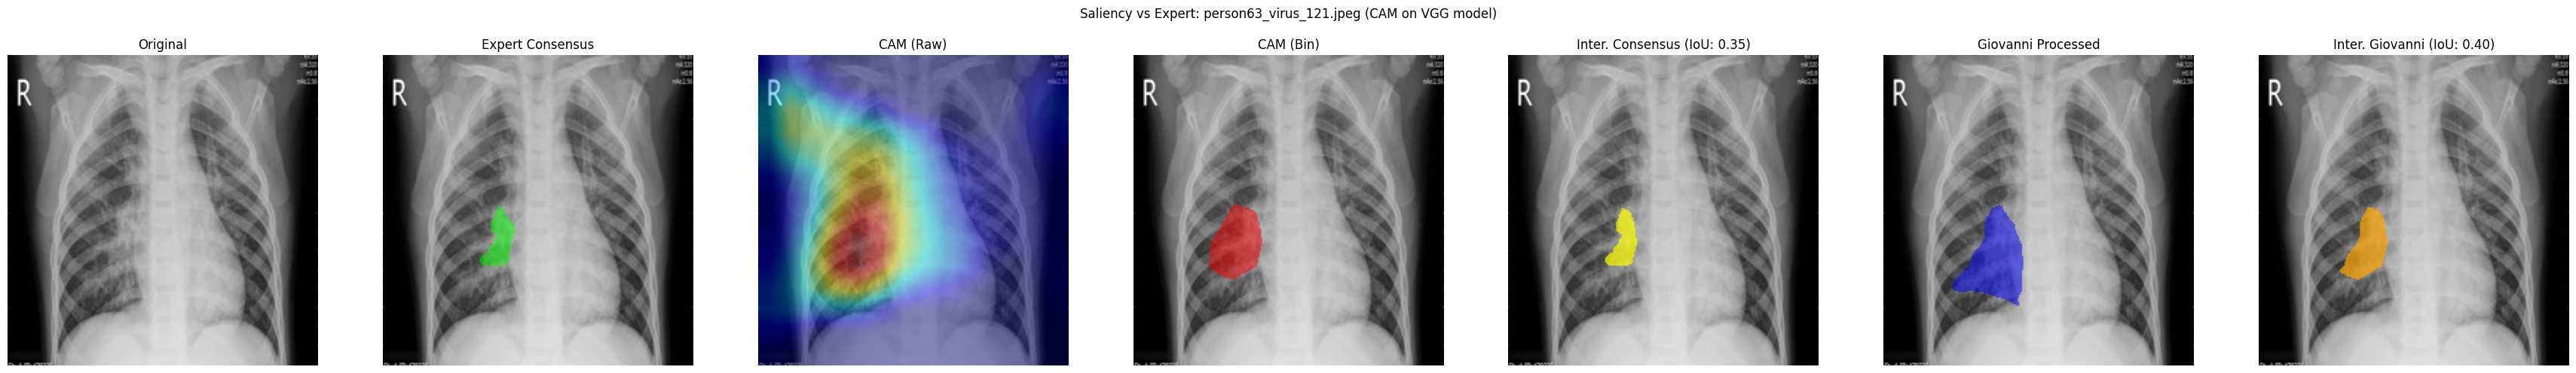

In [33]:
print(f"\n--- Visualizing Saliency Agreement for one image using {saliency_model_name_display if 'saliency_model_name_display' in locals() else MODEL_SHORT_KEY_FOR_SALIENCY.upper()} ---")

# 1. Get images that have a non-empty consensus mask (re-using logic)
valid_consensus_image_names = []
# temp_consensus_masks_dict was used in the original cell 7, ensure it's defined or re-create logic
if 'temp_consensus_masks_dict' not in locals() or not isinstance(temp_consensus_masks_dict, dict):
    temp_consensus_masks_dict = {} # Initialize if not present

unique_images_for_vis = sorted(list(set(record['image_name'] for record in annotations_metadata)))

for img_name_vis_loop in unique_images_for_vis:
    if img_name_vis_loop not in temp_consensus_masks_dict: # Process only if not already cached
        raw_masks_tuples_loop = utils.get_masks_for_image_from_metadata(
            img_name_vis_loop, annotations_metadata, ANNOTATED_MASKS_DIR, target_size=MODEL_INPUT_SIZE
        )
        base_processed_masks_loop = []
        for rm_loop, an_loop in raw_masks_tuples_loop:
            pm_loop = utils.process_circled_annotation(rm_loop, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER)
            if pm_loop is None: pm_loop = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)
            base_processed_masks_loop.append(pm_loop)
        
        if not base_processed_masks_loop: 
            temp_consensus_masks_dict[img_name_vis_loop] = None
            continue
        final_consensus_loop = utils.create_consensus_mask(
            base_processed_masks_loop, CONSENSUS_POST_FILTER_TYPE, CONSENSUS_POST_FILTER_KERNEL_SIZE, CONSENSUS_METHOD
        )
        temp_consensus_masks_dict[img_name_vis_loop] = final_consensus_loop
    
    # Check from cache or newly computed
    if temp_consensus_masks_dict[img_name_vis_loop] is not None and temp_consensus_masks_dict[img_name_vis_loop].sum() > 0:
        valid_consensus_image_names.append(img_name_vis_loop)

if not valid_consensus_image_names:
    print("No images found with non-empty consensus masks. Cannot visualize.")
else:
    sample_image_for_saliency_vis = np.random.choice(valid_consensus_image_names)
    print(f"Selected image for visualization: {sample_image_for_saliency_vis}")

    original_image_path_vis = None
    possible_paths_vis = [
        os.path.join(VIS_ORIGINAL_IMAGES_DIR, "PNEUMONIA", sample_image_for_saliency_vis),
        os.path.join(VIS_ORIGINAL_IMAGES_DIR, "NORMAL", sample_image_for_saliency_vis),
        os.path.join(VIS_ORIGINAL_IMAGES_DIR, sample_image_for_saliency_vis) 
    ]
    for p_path_vis in possible_paths_vis:
        if os.path.exists(p_path_vis):
            original_image_path_vis = p_path_vis
            break
    
    if not original_image_path_vis:
        print(f"ERROR: Original image file not found for {sample_image_for_saliency_vis}")
    else:
        input_tensor_vis = utils.load_image_tensor(original_image_path_vis, device)
        original_pil_img_vis = Image.open(original_image_path_vis).convert("RGB").resize(MODEL_INPUT_SIZE)

        if input_tensor_vis is not None:
            expert_consensus_mask_vis = temp_consensus_masks_dict[sample_image_for_saliency_vis]

            # ---- Find and Process Giovanni's Annotation ----
            giovanni_raw_mask_vis = None
            giovanni_processed_mask_vis = None
            raw_masks_for_selected_image = utils.get_masks_for_image_from_metadata(
                sample_image_for_saliency_vis, annotations_metadata, ANNOTATED_MASKS_DIR, target_size=MODEL_INPUT_SIZE
            )
            for r_mask, annotator_n in raw_masks_for_selected_image:
                if "giovanni" in annotator_n.lower():
                    giovanni_raw_mask_vis = r_mask
                    if giovanni_raw_mask_vis is not None:
                        giovanni_processed_mask_vis = utils.process_circled_annotation(
                            giovanni_raw_mask_vis, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, 
                            OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, 
                            FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER
                        )
                        if giovanni_processed_mask_vis is not None and giovanni_processed_mask_vis.sum() == 0:
                            giovanni_processed_mask_vis = None # Treat as unavailable if processing results in empty
                    break # Found Giovanni
            
            if giovanni_raw_mask_vis is None:
                print(f"  Annotation by 'Giovanni' not found for image {sample_image_for_saliency_vis}.")
            elif giovanni_processed_mask_vis is None:
                print(f"  Annotation by 'Giovanni' found but resulted in an empty mask after processing for {sample_image_for_saliency_vis}.")


            # 4. Generate Saliency Map
            saliency_map_np_vis = None
            saliency_tool_vis = None
            # Ensure SALIENCY_METHOD_TO_VISUALIZE, loaded_saliency_model, etc. are defined from Cell 6
            # Defaulting here if not set in Cell 6 for standalone running of this cell (less robust)
            current_saliency_method = SALIENCY_METHOD_TO_VISUALIZE if 'SALIENCY_METHOD_TO_VISUALIZE' in locals() else "GradCAM"
            current_rise_masks = RISE_NUM_MASKS_VIS if 'RISE_NUM_MASKS_VIS' in locals() else 200
            current_rise_scale = RISE_SCALE_FACTOR_VIS if 'RISE_SCALE_FACTOR_VIS' in locals() else 16


            if current_saliency_method == "CAM":
                if hasattr(saliency, 'CAM') and isinstance(loaded_saliency_model, (AlexNetBinary, VGG16Binary, ResNet50Binary, InceptionNetBinary)):
                    saliency_tool_vis = saliency.CAM(loaded_saliency_model)
            elif current_saliency_method == "GradCAM":
                if hasattr(saliency, 'GradCAM'): saliency_tool_vis = saliency.GradCAM(loaded_saliency_model)
            elif current_saliency_method == "RISE":
                if hasattr(saliency, 'RISE'): saliency_tool_vis = saliency.RISE(loaded_saliency_model, num_masks=current_rise_masks, scale_factor=current_rise_scale)
            elif current_saliency_method == "Random":
                saliency_map_np_vis = utils.generate_random_map(size=MODEL_INPUT_SIZE)
            
            if saliency_tool_vis:
                try:
                    print(f"  Generating {current_saliency_method} map...")
                    saliency_map_np_vis = saliency_tool_vis(input_tensor_vis)
                except Exception as e: print(f"    Error generating {current_saliency_method}: {e}")
            
            if saliency_map_np_vis is not None:
                current_bin_thresh = VIS_SALIENCY_BINARIZATION_THRESHOLD if 'VIS_SALIENCY_BINARIZATION_THRESHOLD' in locals() else 0.5
                binarized_saliency_map_vis = utils.binarize_saliency_map(saliency_map_np_vis, threshold_value=current_bin_thresh)

                iou_score_consensus_vis = utils.calculate_iou(binarized_saliency_map_vis, expert_consensus_mask_vis)
                print(f"  IoU Model-Consensus: {iou_score_consensus_vis:.4f}")

                iou_score_giovanni_vis = np.nan
                if giovanni_processed_mask_vis is not None:
                    iou_score_giovanni_vis = utils.calculate_iou(binarized_saliency_map_vis, giovanni_processed_mask_vis)
                    print(f"  IoU Model-Giovanni: {iou_score_giovanni_vis:.4f}")

                # Visualization (now 7 panels if Giovanni's mask is available)
                num_panels = 5
                if giovanni_processed_mask_vis is not None:
                    num_panels = 7
                
                fig_vis, axes_vis = plt.subplots(1, num_panels, figsize=(num_panels * 5, 5))

                axes_vis[0].imshow(original_pil_img_vis); axes_vis[0].set_title("Original"); axes_vis[0].axis('off')
                
                overlay_expert_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), expert_consensus_mask_vis, mask_color=(0, 255, 0), alpha=0.5)
                axes_vis[1].imshow(overlay_expert_vis); axes_vis[1].set_title("Expert Consensus"); axes_vis[1].axis('off')

                saliency_map_display = cv2.resize(saliency_map_np_vis, (original_pil_img_vis.width, original_pil_img_vis.height))
                saliency_heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map_display), cv2.COLORMAP_JET)
                saliency_heatmap_rgb = cv2.cvtColor(saliency_heatmap, cv2.COLOR_BGR2RGB)
                overlay_raw_saliency = cv2.addWeighted(np.array(original_pil_img_vis), 0.6, saliency_heatmap_rgb, 0.4, 0)
                axes_vis[2].imshow(overlay_raw_saliency); axes_vis[2].set_title(f"{current_saliency_method} (Raw)"); axes_vis[2].axis('off')
                
                overlay_bin_saliency_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), binarized_saliency_map_vis, mask_color=(255, 0, 0), alpha=0.5)
                axes_vis[3].imshow(overlay_bin_saliency_vis); axes_vis[3].set_title(f"{current_saliency_method} (Bin)"); axes_vis[3].axis('off')

                intersection_consensus_vis = np.logical_and(binarized_saliency_map_vis, expert_consensus_mask_vis).astype(np.uint8)
                overlay_inter_consensus_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), intersection_consensus_vis, mask_color=(255, 255, 0), alpha=0.7)
                axes_vis[4].imshow(overlay_inter_consensus_vis); axes_vis[4].set_title(f"Inter. Consensus (IoU: {iou_score_consensus_vis:.2f})"); axes_vis[4].axis('off')

                if giovanni_processed_mask_vis is not None:
                    overlay_giovanni_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), giovanni_processed_mask_vis, mask_color=(0, 0, 255), alpha=0.5) # Blue for Giovanni
                    axes_vis[5].imshow(overlay_giovanni_vis); axes_vis[5].set_title("Giovanni Processed"); axes_vis[5].axis('off')

                    intersection_giovanni_vis = np.logical_and(binarized_saliency_map_vis, giovanni_processed_mask_vis).astype(np.uint8)
                    overlay_inter_giovanni_vis = utils.overlay_binary_mask(original_pil_img_vis.copy(), intersection_giovanni_vis, mask_color=(255, 165, 0), alpha=0.7) # Orange for Giovanni intersection
                    axes_vis[6].imshow(overlay_inter_giovanni_vis); axes_vis[6].set_title(f"Inter. Giovanni (IoU: {iou_score_giovanni_vis:.2f})"); axes_vis[6].axis('off')
                
                current_model_name_display = saliency_model_name_display if 'saliency_model_name_display' in locals() else MODEL_SHORT_KEY_FOR_SALIENCY.upper()
                plt.suptitle(f"Saliency vs Expert: {sample_image_for_saliency_vis} ({current_saliency_method} on {current_model_name_display})", fontsize=12)
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                plt.show()
            else:
                print(f"  Could not generate {current_saliency_method} map for the selected image.")



--- Aggregated Saliency Analysis for VGG model using CAM ---
Note: Displayed IoUs are averages of per-image IoUs.
Processing 50 unique images for potential aggregation and IoU calculation...

Calculated per-image IoUs for 31 images.

--- Average Per-Image IoU Results (CAM on VGG model) ---
  Avg. IoU vs Full Expert Consensus: 0.1826 (from 31 images)
  Avg. IoU vs Giovanni Only:         0.2056 (from 31 images with non-empty Giovanni mask)
  Avg. IoU vs Consensus (No Gio):    0.1569 (from 21 images with non-empty NoGio consensus)


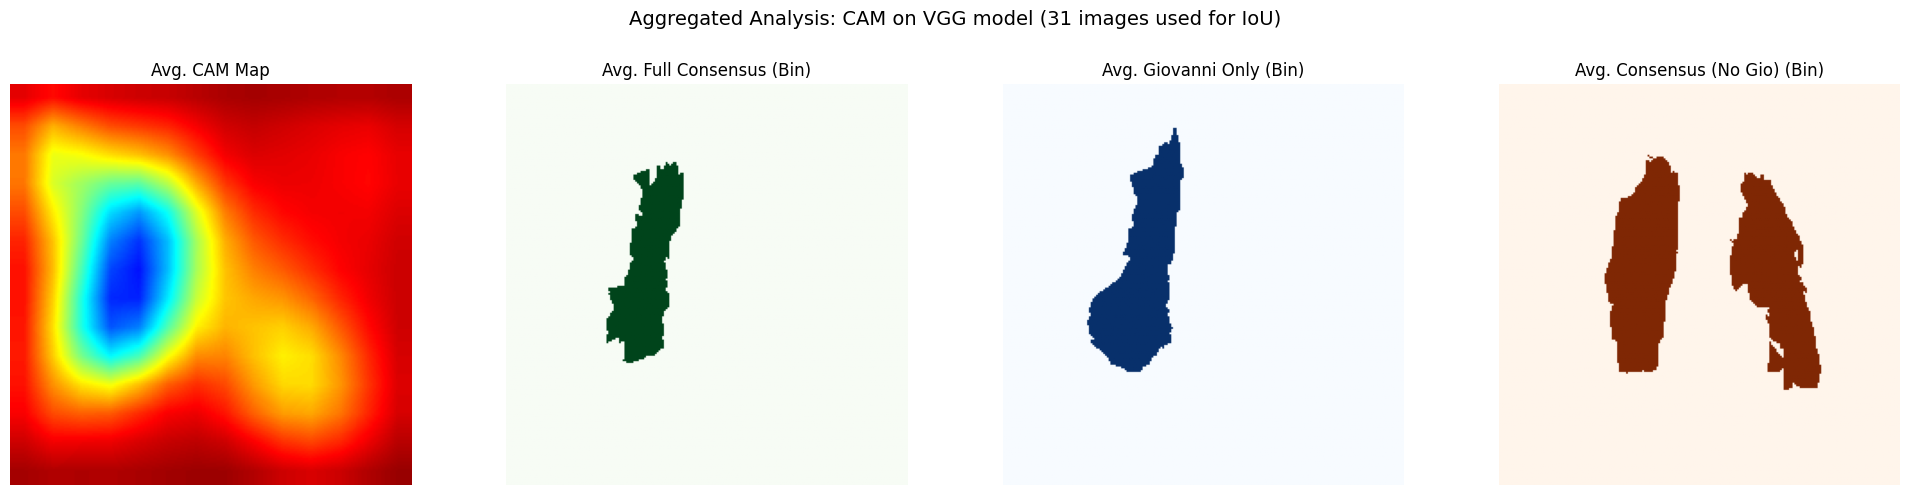

In [41]:
# Cell 7 (New - Corrected IoU Logic): Aggregated Saliency and Expert Annotation Analysis

# This cell assumes necessary variables (loaded_saliency_model, annotations_metadata, device,
# MODEL_INPUT_SIZE, VIS_ORIGINAL_IMAGES_DIR, ANNOTATED_MASKS_DIR, saliency_model_name_display,
# INITIAL_PRE_CLOSING_KERNEL_SIZE, etc.) are defined from previous setup cells (e.g., Cell 1-6).
# It also assumes utils, saliency, models modules are imported.

# --- Configuration for Aggregation ---
# These would typically be set in a cell like Cell 6
current_saliency_method_to_aggregate = SALIENCY_METHOD_TO_VISUALIZE if 'SALIENCY_METHOD_TO_VISUALIZE' in locals() else "GradCAM"
agg_saliency_bin_thresh = VIS_SALIENCY_BINARIZATION_THRESHOLD if 'VIS_SALIENCY_BINARIZATION_THRESHOLD' in locals() else 0.5
# agg_expert_bin_thresh is used for visualizing the average expert masks, not for IoU calculation here.
agg_expert_bin_thresh_for_viz = 0.2 

saliency_model_name_for_title = saliency_model_name_display if 'saliency_model_name_display' in locals() else MODEL_SHORT_KEY_FOR_SALIENCY.upper()
current_rise_masks_agg = RISE_NUM_MASKS_VIS if 'RISE_NUM_MASKS_VIS' in locals() else 200
current_rise_scale_agg = RISE_SCALE_FACTOR_VIS if 'RISE_SCALE_FACTOR_VIS' in locals() else 16


if 'loaded_saliency_model' in locals() and loaded_saliency_model and \
   'annotations_metadata' in locals() and annotations_metadata and \
   'utils' in sys.modules and 'saliency' in sys.modules:

    print(f"\n--- Aggregated Saliency Analysis for {saliency_model_name_for_title} using {current_saliency_method_to_aggregate} ---")
    print(f"Note: Displayed IoUs are averages of per-image IoUs.")

    # Initialize lists to store individual maps for *visual aggregation only*
    all_saliency_maps_for_avg_viz = []
    all_full_expert_consensus_for_avg_viz = []
    all_giovanni_processed_for_avg_viz = []
    all_no_giovanni_consensus_for_avg_viz = []

    # Initialize lists to store per-image IoU scores
    per_image_ious_vs_full_consensus = []
    per_image_ious_vs_giovanni = []
    per_image_ious_vs_no_giovanni = []

    unique_images_for_agg = sorted(list(set(record['image_name'] for record in annotations_metadata)))
    print(f"Processing {len(unique_images_for_agg)} unique images for potential aggregation and IoU calculation...")

    processed_for_iou_count = 0

    for loop_idx, image_name_agg in enumerate(unique_images_for_agg):
        # A. Generate/Retrieve Full Expert Consensus for this image
        raw_masks_tuples_full = utils.get_masks_for_image_from_metadata(
            image_name_agg, annotations_metadata, ANNOTATED_MASKS_DIR, target_size=MODEL_INPUT_SIZE
        )
        if not raw_masks_tuples_full: continue

        base_processed_masks_full = []
        for rm_full, an_full in raw_masks_tuples_full:
            pm_full = utils.process_circled_annotation(rm_full, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER)
            if pm_full is None: pm_full = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)
            base_processed_masks_full.append(pm_full)
        
        current_full_expert_consensus = utils.create_consensus_mask(
            base_processed_masks_full, CONSENSUS_POST_FILTER_TYPE, CONSENSUS_POST_FILTER_KERNEL_SIZE, CONSENSUS_METHOD
        )

        if current_full_expert_consensus is None or current_full_expert_consensus.sum() == 0:
            continue # Only process images with a meaningful overall consensus for this analysis

        # B. Find and Process Giovanni's Annotation
        giovanni_processed_mask_agg = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)
        found_giovanni_for_img = False
        for r_mask_g, annotator_n_g in raw_masks_tuples_full:
            if "giovanni" in annotator_n_g.lower():
                found_giovanni_for_img = True
                if r_mask_g is not None:
                    temp_gio_processed = utils.process_circled_annotation(
                        r_mask_g, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, 
                        OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, 
                        FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER
                    )
                    if temp_gio_processed is not None and temp_gio_processed.sum() > 0:
                        giovanni_processed_mask_agg = temp_gio_processed
                break
        
        # C. Generate "Consensus without Giovanni"
        masks_for_no_giovanni_consensus = []
        for r_mask_ng, annotator_n_ng in raw_masks_tuples_full:
            if "giovanni" not in annotator_n_ng.lower():
                pm_ng = utils.process_circled_annotation(r_mask_ng, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER)
                if pm_ng is None: pm_ng = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)
                masks_for_no_giovanni_consensus.append(pm_ng)
        
        current_no_giovanni_consensus = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)
        if masks_for_no_giovanni_consensus:
            current_no_giovanni_consensus = utils.create_consensus_mask(
                masks_for_no_giovanni_consensus, CONSENSUS_POST_FILTER_TYPE, CONSENSUS_POST_FILTER_KERNEL_SIZE, CONSENSUS_METHOD
            )
            if current_no_giovanni_consensus is None: 
                 current_no_giovanni_consensus = np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8)

        # D. Generate Saliency Map for this image
        original_image_path_agg = None
        possible_paths_agg = [
            os.path.join(VIS_ORIGINAL_IMAGES_DIR, "PNEUMONIA", image_name_agg),
            os.path.join(VIS_ORIGINAL_IMAGES_DIR, "NORMAL", image_name_agg),
            os.path.join(VIS_ORIGINAL_IMAGES_DIR, image_name_agg) 
        ]
        for p_path_agg in possible_paths_agg:
            if os.path.exists(p_path_agg): original_image_path_agg = p_path_agg; break
        
        if not original_image_path_agg: continue
        input_tensor_agg = utils.load_image_tensor(original_image_path_agg, device)
        if input_tensor_agg is None: continue

        saliency_map_np_agg = None; saliency_tool_agg = None
        if current_saliency_method_to_aggregate == "CAM":
            if hasattr(saliency, 'CAM') and isinstance(loaded_saliency_model, (AlexNetBinary, VGG16Binary, ResNet50Binary, InceptionNetBinary)):
                saliency_tool_agg = saliency.CAM(loaded_saliency_model)
        elif current_saliency_method_to_aggregate == "GradCAM":
            if hasattr(saliency, 'GradCAM'): saliency_tool_agg = saliency.GradCAM(loaded_saliency_model)
        elif current_saliency_method_to_aggregate == "RISE":
            if hasattr(saliency, 'RISE'): saliency_tool_agg = saliency.RISE(loaded_saliency_model, num_masks=current_rise_masks_agg, scale_factor=current_rise_scale_agg)
        
        if saliency_tool_agg:
            try: saliency_map_np_agg = saliency_tool_agg(input_tensor_agg)
            except Exception as e: print(f"    Error generating saliency for {image_name_agg}: {e}")
        
        if saliency_map_np_agg is None: continue 

        # E. Binarize current saliency map
        bin_current_saliency = utils.binarize_saliency_map(saliency_map_np_agg, threshold_value=agg_saliency_bin_thresh)
        if bin_current_saliency is None: continue

        # F. Calculate and store per-image IoUs
        per_image_ious_vs_full_consensus.append(utils.calculate_iou(bin_current_saliency, current_full_expert_consensus))
        
        if giovanni_processed_mask_agg.sum() > 0: # Only calculate IoU if Giovanni's mask is non-empty
            per_image_ious_vs_giovanni.append(utils.calculate_iou(bin_current_saliency, giovanni_processed_mask_agg))
        # else: per_image_ious_vs_giovanni.append(np.nan) # Or handle how to average if some are missing

        if current_no_giovanni_consensus.sum() > 0: # Only calculate IoU if no-Giovanni consensus is non-empty
            per_image_ious_vs_no_giovanni.append(utils.calculate_iou(bin_current_saliency, current_no_giovanni_consensus))
        # else: per_image_ious_vs_no_giovanni.append(np.nan)

        # G. Add to lists for *visual aggregation only*
        all_saliency_maps_for_avg_viz.append(saliency_map_np_agg) # Store raw for averaging heatmap
        all_full_expert_consensus_for_avg_viz.append(current_full_expert_consensus)
        all_giovanni_processed_for_avg_viz.append(giovanni_processed_mask_agg) 
        all_no_giovanni_consensus_for_avg_viz.append(current_no_giovanni_consensus)
        processed_for_iou_count += 1

    print(f"\nCalculated per-image IoUs for {processed_for_iou_count} images.")

    if processed_for_iou_count > 0:
        # 2. Calculate Average of Per-Image IoUs
        avg_iou_vs_full_consensus = np.nanmean(per_image_ious_vs_full_consensus) if per_image_ious_vs_full_consensus else np.nan
        avg_iou_vs_giovanni = np.nanmean(per_image_ious_vs_giovanni) if per_image_ious_vs_giovanni else np.nan
        avg_iou_vs_no_giovanni = np.nanmean(per_image_ious_vs_no_giovanni) if per_image_ious_vs_no_giovanni else np.nan
        
        print(f"\n--- Average Per-Image IoU Results ({current_saliency_method_to_aggregate} on {saliency_model_name_for_title}) ---")
        print(f"  Avg. IoU vs Full Expert Consensus: {avg_iou_vs_full_consensus:.4f} (from {len(per_image_ious_vs_full_consensus)} images)")
        print(f"  Avg. IoU vs Giovanni Only:         {avg_iou_vs_giovanni:.4f} (from {len(per_image_ious_vs_giovanni)} images with non-empty Giovanni mask)")
        print(f"  Avg. IoU vs Consensus (No Gio):    {avg_iou_vs_no_giovanni:.4f} (from {len(per_image_ious_vs_no_giovanni)} images with non-empty NoGio consensus)")

        # 3. Aggregate maps for visualization (averaging)
        avg_saliency_map_viz = np.mean([m for m in all_saliency_maps_for_avg_viz if isinstance(m, np.ndarray)], axis=0) if all_saliency_maps_for_avg_viz else np.zeros(MODEL_INPUT_SIZE)
        avg_full_expert_viz = np.mean([m for m in all_full_expert_consensus_for_avg_viz if isinstance(m, np.ndarray)], axis=0) if all_full_expert_consensus_for_avg_viz else np.zeros(MODEL_INPUT_SIZE)
        
        valid_giovanni_masks_viz = [m for m in all_giovanni_processed_for_avg_viz if isinstance(m, np.ndarray) and m.sum() > 0]
        avg_giovanni_viz = np.mean(valid_giovanni_masks_viz, axis=0) if valid_giovanni_masks_viz else np.zeros(MODEL_INPUT_SIZE)
        
        avg_no_giovanni_viz = np.mean([m for m in all_no_giovanni_consensus_for_avg_viz if isinstance(m, np.ndarray)], axis=0) if all_no_giovanni_consensus_for_avg_viz else np.zeros(MODEL_INPUT_SIZE)

        # Binarize these *averaged* expert maps for visualization purposes
        bin_avg_full_expert_viz = (avg_full_expert_viz > agg_expert_bin_thresh_for_viz).astype(np.uint8)
        bin_avg_giovanni_viz = (avg_giovanni_viz > agg_expert_bin_thresh_for_viz).astype(np.uint8)
        bin_avg_no_giovanni_viz = (avg_no_giovanni_viz > agg_expert_bin_thresh_for_viz).astype(np.uint8)

        # 4. Visualization of Aggregated Maps
        fig_agg, axes_agg = plt.subplots(1, 4, figsize=(20, 5))
        
        agg_saliency_display = cv2.resize(avg_saliency_map_viz, MODEL_INPUT_SIZE)
        agg_saliency_heatmap = cv2.applyColorMap(np.uint8(255 * np.clip(agg_saliency_display,0,1)), cv2.COLORMAP_JET)
        axes_agg[0].imshow(agg_saliency_heatmap)
        axes_agg[0].set_title(f"Avg. {current_saliency_method_to_aggregate} Map")
        axes_agg[0].axis('off')

        axes_agg[1].imshow(bin_avg_full_expert_viz, cmap='Greens'); axes_agg[1].set_title("Avg. Full Consensus (Bin)"); axes_agg[1].axis('off')
        axes_agg[2].imshow(bin_avg_giovanni_viz, cmap='Blues'); axes_agg[2].set_title("Avg. Giovanni Only (Bin)"); axes_agg[2].axis('off')
        axes_agg[3].imshow(bin_avg_no_giovanni_viz, cmap='Oranges'); axes_agg[3].set_title("Avg. Consensus (No Gio) (Bin)"); axes_agg[3].axis('off')

        plt.suptitle(f"Aggregated Analysis: {current_saliency_method_to_aggregate} on {saliency_model_name_for_title} ({processed_for_iou_count} images used for IoU)", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
    else:
        print("No images were processed for IoU calculation (e.g., all had empty consensus or saliency failed).")
else:
    print("\nSkipping aggregated saliency analysis: Essential variables (model, metadata, utils, etc.) not loaded or defined from previous cells.")

